# W266 Final Project - Amazon Reviews

This notebook is to read in the cleaned data and work with the data in keras.

http://jmcauley.ucsd.edu/data/amazon/links.html

In [1]:
import pandas as pd
import gzip
import random
from collections import defaultdict
import seaborn as sns
import numpy as np
import re

from nltk.corpus import stopwords
import string

import tensorflow_hub as hub
import tensorflow as tf

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, Input
from keras.layers.embeddings import Embedding
from keras.layers.merge import concatenate
from keras.utils.vis_utils import plot_model
from keras.models import Model

import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

/home/lance_miles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
W0328 01:11:14.086686 140345287345984 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14
Using TensorFlow backend.


In [2]:
files = ['reviews_Video_Games.json.gz', 
         'reviews_Toys_and_Games.json.gz', 
         'reviews_Sports_and_Outdoors.json.gz', 
         'reviews_Movies_and_TV.json.gz',
         'reviews_Kindle_Store.json.gz', 
         'reviews_Home_and_Kitchen.json.gz',
         'reviews_Health_and_Personal_Care.json.gz', 
         'reviews_Electronics.json.gz',
         'reviews_Clothing_Shoes_and_Jewelry.json.gz',
         'reviews_Cell_Phones_and_Accessories.json.gz', 
         'reviews_CDs_and_Vinyl.json.gz',
         'reviews_Books.json.gz']
filesNames = ['reviews_Video_Games', 
              'reviews_Toys_and_Games',
              'reviews_Sports_and_Outdoors', 
              'reviews_Movies_and_TV',
              'reviews_Kindle_Store', 
              'reviews_Home_and_Kitchen',
              'reviews_Health_and_Personal_Care', 
              'reviews_Electronics',
              'reviews_Clothing_Shoes_and_Jewelry',
              'reviews_Cell_Phones_and_Accessories', 
              'reviews_CDs_and_Vinyl',
              'reviews_Books']

def dataFullSets(original, concatData, name):
    currentData = original
    appendData = pd.read_csv('../Data/%s'%(concatData))
    appendData['Product'] = name
    newDF = pd.concat([currentData,appendData])
    return(newDF)

train_data = pd.read_csv('../Data/%s_train.csv'%(filesNames[0]))
train_data['Product'] = filesNames[0]
test_data = pd.read_csv('../Data/%s_test.csv'%(filesNames[0]))
test_data['Product'] = filesNames[0]

random.seed(1203)

for fileName in filesNames[1:]:
    concatName_train = str(fileName+'_train.csv')
    concatName_test = fileName+'_test.csv'
                        
    train_data = dataFullSets(train_data, concatName_train, fileName).sample(frac=1)
    test_data = dataFullSets(test_data, concatName_test, fileName).sample(frac=1)

/home/lance_miles/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



In [3]:
train_data.head()

,Product,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,sentiment,summary,unixReviewTime
60727,reviews_Health_and_Personal_Care,B001ECQ72S,"[0, 0]",5.0,Amazon offers the pack of 3 for the same price...,"09 4, 2011",A3RL90G39VP7DD,"Jessica R. Richards ""Miss Jess""",1,CANNOT BEAT THE PRICE,1315094400
65842,reviews_Toys_and_Games,B000GFJAZU,"[0, 1]",1.0,The boat is great. Loved the propeller drive ...,"02 4, 2012",A20WXI56F4VJI0,western,0,propeller,1328313600
75259,reviews_Movies_and_TV,630150528X,"[3, 16]",1.0,"We received the DVD in a timely manner, but wh...","04 2, 2009",A1GGZ0MK5L95QV,A. Degregorio,0,The African Queen,1238630400
90632,reviews_Electronics,B003DZ1652,"[0, 0]",5.0,Really just what I wanted and works very nice...,"10 6, 2010",AUKTNR0B28DFU,"W. S. Johnston ""Wanlyn""",1,KINDLE BOOK COVER,1286323200
63590,reviews_Movies_and_TV,B002VECLVO,"[9, 75]",1.0,This is possible the worst movie that I have s...,"09 27, 2010",A2VBGC203PW4U8,"E. Stanford ""beach belle""",0,stay away,1285545600


In [4]:
test_data.head()

,Product,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,sentiment,summary,unixReviewTime
15945,reviews_Toys_and_Games,B000H6DWSY,"[1, 1]",1.0,The suction cups are not big enough to hold up...,"06 16, 2007",A1P67VA81DMVKN,KCBlueGal,0,Don't even waste your money,1181952000
4837,reviews_Electronics,B002NKNWAA,"[0, 0]",1.0,Was not the right battery ... Pic that was on ...,"10 22, 2013",A25WAQ4PLMA9EM,k9,0,why me,1382400000
6504,reviews_Kindle_Store,B00BG52E7U,"[0, 0]",5.0,"In the waning years of the Weimar Republic, Se...","06 22, 2014",A1BM2S6I7QTCOF,Wolfgang Manowski,1,Anti-Nazi Propaganda Effort,1403395200
15937,reviews_Books,B00DYV8NKQ,"[8, 11]",1.0,I purchased this because I enjoyed Hugh 's Sil...,"08 24, 2013",A1IS7P2WM8ASFP,Amazon Customer,0,Not the same as Hugh,1377302400
5978,reviews_Health_and_Personal_Care,B000F8KAKC,"[0, 0]",1.0,"In the description of this product, it says th...","11 20, 2007",A31ZCAL11QQPI,Dr. C.,0,Wrong!!,1195516800


In [5]:
#practice sentence
test_sentence = test_data['reviewText'].iloc[19]
test_sentence

'I bought this the end of December (2013). I dieted for a month got on the scale and it showed I had lost 10lbs. I weighed myself two weeks later and it showed I had lost 13 lbs. If you want to &#34;believe&#34; you lost weight while eating as much if not more than you normally do this scale is for you!'

In [6]:
#prepare reviews to be split by words
#change to lowercase, remove punctuation and numbers
test_data_word_prep = re.sub("[^a-zA-Z]", " ", test_sentence).lower()
test_data_word_prep

'i bought this the end of december         i dieted for a month got on the scale and it showed i had lost   lbs  i weighed myself two weeks later and it showed i had lost    lbs  if you want to      believe      you lost weight while eating as much if not more than you normally do this scale is for you '

In [7]:
#list of words after processing
test_data_word_prep.strip().split()

['i',
 'bought',
 'this',
 'the',
 'end',
 'of',
 'december',
 'i',
 'dieted',
 'for',
 'a',
 'month',
 'got',
 'on',
 'the',
 'scale',
 'and',
 'it',
 'showed',
 'i',
 'had',
 'lost',
 'lbs',
 'i',
 'weighed',
 'myself',
 'two',
 'weeks',
 'later',
 'and',
 'it',
 'showed',
 'i',
 'had',
 'lost',
 'lbs',
 'if',
 'you',
 'want',
 'to',
 'believe',
 'you',
 'lost',
 'weight',
 'while',
 'eating',
 'as',
 'much',
 'if',
 'not',
 'more',
 'than',
 'you',
 'normally',
 'do',
 'this',
 'scale',
 'is',
 'for',
 'you']

In [8]:
#prepare reviews to be split by sentences
#change to lowercase, changes (!?) to (.), removes numbers, allows to be split by periods
test_data_sent_prep = re.sub("[!?]", ".", test_sentence)
test_data_sent_prep = re.sub("[^a-zA-Z.]", " ", test_data_sent_prep).lower()
test_data_sent_prep

'i bought this the end of december       . i dieted for a month got on the scale and it showed i had lost   lbs. i weighed myself two weeks later and it showed i had lost    lbs. if you want to      believe      you lost weight while eating as much if not more than you normally do this scale is for you.'

In [9]:
#list of sentences after processing
[sent.strip(" ") for sent in test_data_sent_prep.split('.')]

['i bought this the end of december',
 'i dieted for a month got on the scale and it showed i had lost   lbs',
 'i weighed myself two weeks later and it showed i had lost    lbs',
 'if you want to      believe      you lost weight while eating as much if not more than you normally do this scale is for you',
 '']

In [10]:
play_data = test_data[:10]
#print(play_data)

#function to process review text and split into words
def splitWords(data):
    data_prep = str(data['reviewText'])
    data_prep = re.sub("[^a-zA-Z]", " ", data_prep).lower()
    return data_prep.split()

#function to process review text and split into sentences
def splitSentences(data):
    data_prep = str(data['reviewText'])
    data_prep = re.sub("[!?]", ".", data_prep)
    data_prep = re.sub("[^a-zA-Z.]", " ", data_prep).lower().split('.')
    data_prep = [sentence.strip(" ") for sentence in data_prep]
    return data_prep


#list of words from review into column
sentences = play_data.apply(splitWords, axis=1)
play_data.insert(loc = 11, column = 'sentenceWords', value = sentences)

sentences = train_data.apply(splitWords, axis=1)
train_data.insert(loc = 11,column = 'sentenceWords', value = sentences)

sentences = test_data.apply(splitWords, axis=1)
test_data.insert(loc = 11,column = 'sentenceWords', value = sentences)


#list of sentences from review into column
sentences_split = play_data.apply(splitSentences, axis=1)
play_data.insert(loc = 12, column = 'sentences', value = sentences_split)

sentences_split = train_data.apply(splitSentences, axis=1)
train_data.insert(loc = 12,column = 'sentences', value = sentences_split)

sentences_split = test_data.apply(splitSentences, axis=1)
test_data.insert(loc = 12,column = 'sentences', value = sentences_split)

In [11]:
wordFreq = defaultdict(int)

wordData = train_data['sentenceWords']

for row in wordData:
    for word in row:
        wordFreq[word] += 1      

In [12]:
wordsForHist = list(wordFreq.values())

/home/lance_miles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Word Frequency for Train Data')

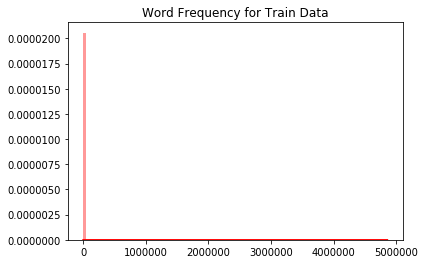

In [13]:
sns.distplot(wordsForHist, bins=100, color = 'red').set_title('Word Frequency for Train Data')

In [14]:
reviewLength = []

for row in wordData:
    reviewLength.append(len(row))

/home/lance_miles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Sentence Lengths for Train Data')

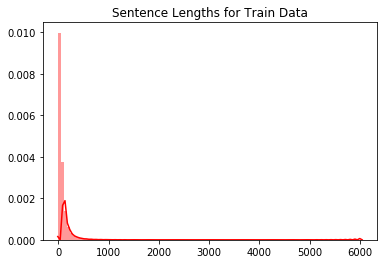

In [15]:
sns.distplot(reviewLength, bins=100, color = 'red').set_title('Sentence Lengths for Train Data')

In [16]:
print('Mean:',np.mean(reviewLength))
print('Median:',np.median(reviewLength))

Mean: 81.19317833333334
Median: 47.0


## Universal Sentence Encoder

In [17]:
embedding = hub.Module("https://tfhub.dev/google/universal-sentence-encoder-large/3")

In [18]:
test_par = [str(sent) for sent in (play_data['reviewText'])]
test_par

['The suction cups are not big enough to hold up this fairly heavy toy. The toy stayed on the wall, albeit a bit wobbly, until I pumped the toy full of water. *PLOP* right into the tub. After that, it wouldn\'t stay on the wall because I couldn\'t get the suction cups nor the wall dry enough for it to mount, and it kept sliding right into the bath water.The other reviewers were correct in stating that the first time, you have to pump this toy about 15 times to get the toy full of water, and then it only squirts out measly teaspoons of water at a time.I can easily believe that children under four years old will have a difficult time pushing the button hard enough to get the water to squirt, as other reviewers have mentioned. I can only imagine the resulting consequences if a younger child pushed so hard, she or he lost her seated balance in the tub, and went face-first into the water, or smashed his/her head on the bathtub wall or faucet.  Yet, the product dangerously markets itself to 

In [19]:
#supress messages
tf.logging.set_verbosity(tf.logging.ERROR)

with tf.Session() as sess:
    sess.run([tf.global_variables_initializer(), tf.tables_initializer()])
    review_embeddings = sess.run(embedding((test_par)))
    
review_embeddings = np.array(review_embeddings)
review_embeddings.shape

(10, 512)

In [27]:
#review_embeddings

## Keras

### TO DO:

**Model Efforts**
* Initialize and access word2vec embeddings in CNN
* Initialize and access glove embeddings in CNN
* Index Universal Sentence Embeddings for concatenation in CNN

**Text Processing**
* Contractions
* Review Length (some as large as 6000?!)
* Stopwords

### Baseline Models
#### CNN
* Trained Embeddings
* Word2Vec
* Glove

#### Softmax
* Universal Sentence Encoder (USE)

### Models to Test
#### CNN (Concatentation)
* Trained Embeddings + USE
* Word2Vec + USE
* Glove + USE

**If extra time**
* Zero shot learning - IMDB Reviews
* Sentiment embeddings

In [20]:
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen       = 300   # max number of words in a comment to use 

list_sentences_train = list(play_data['reviewText'])

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)

X_train = pad_sequences(list_tokenized_train, maxlen=maxlen, padding='post')

X_train.shape 

(10, 300)

In [21]:
X_train_labels = np.array(play_data['sentiment'])
X_train_labels

array([0, 0, 1, 0, 0, 0, 0, 1, 1, 1])

In [22]:
list_words_play = list(play_data['sentenceWords'])

word_index = tokenizer.word_index

## Word2Vec Embeddings

In [27]:
#https://www.kaggle.com/umbertogriffo/cnn-yoon-kim-s-model-and-google-s-word2vec-model
#https://www.kaggle.com/marijakekic/cnn-in-keras-with-pretrained-word2vec-weights
word_vectors = KeyedVectors.load_word2vec_format('../../GoogleNews-vectors-negative300.bin.gz', binary=True)

embedDim=300
vocabulary_size=len(word_index)+1
embedding_matrix_w2v = np.zeros((vocabulary_size, embedDim))

for word, i in word_index.items():
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix_w2v[i] = embedding_vector
    except KeyError:
        embedding_matrix_w2v[i]=np.random.normal(0,np.sqrt(0.25),embedDim)

del(word_vectors)

In [28]:
embedding_matrix_w2v

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.08007812,  0.10498047,  0.04980469, ...,  0.00366211,
         0.04760742, -0.06884766],
       [-0.17394402,  0.13729602, -0.30038901, ..., -0.41991443,
         0.08470176,  0.49692143],
       ...,
       [ 0.22753906,  0.12011719,  0.06835938, ..., -0.12988281,
         0.05151367, -0.03088379],
       [ 0.203125  , -0.12304688, -0.02966309, ..., -0.0859375 ,
         0.13378906,  0.02062988],
       [-0.07373047,  0.06030273,  0.10791016, ..., -0.16796875,
        -0.21972656, -0.00239563]])

In [36]:
embedding_matrix_w2v.shape

(407, 300)

## Glove Embeddings

In [62]:
#https://www.kaggle.com/umbertogriffo/cnn-yoon-kim-s-model-and-google-s-word2vec-model
#https://www.kaggle.com/marijakekic/cnn-in-keras-with-pretrained-word2vec-weights

# embeddings_index = dict()
# f = open('../../glove.840B.300d.txt')
# for line in f:
#     values = line.split()
#     word = ''.join(values[:-300])
#     coefs = np.asarray(values[-300:], dtype='float32')
#     embeddings_index[word] = coefs
# f.close()

# embedding_matrix_glove = np.zeros((vocabulary_size, embedDim))
# for word, i in word_index.items():
#     try:
#         embedding_vector = embeddings_index.get(word)
#         embedding_matrix_glove[i] = embedding_vector
#     except KeyError:
#         embedding_matrix_glove[i]=np.random.normal(0,np.sqrt(0.25),embedDim)

In [ ]:
# https://stackoverflow.com/questions/37793118/load-pretrained-glove-vectors-in-python
# import warnings
# warnings.filterwarnings("ignore")

_ = glove2word2vec(glove_input_file='../../glove.840B.300d.txt', 
                   word2vec_output_file='../../gensim_glove_vectors.txt')

In [23]:
word_vectors = KeyedVectors.load_word2vec_format('../../gensim_glove_vectors.txt', binary=False)

W0328 01:16:25.567910 140345287345984 utils_any2vec.py:185] duplicate word '����������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������������' in gensim_glove_vectors.txt, ignoring all but first


In [25]:
embedding_matrix_glove = np.zeros((vocabulary_size, embedDim))
for word, i in word_index.items():
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix_glove[i] = embedding_vector
    except KeyError:
        embedding_matrix_glove[i]=np.random.normal(0,np.sqrt(0.25),embedDim)

del(word_vectors)

In [26]:
embedding_matrix_glove

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.72040009e-01, -6.20299987e-02, -1.88400000e-01, ...,
         1.30150005e-01, -1.83170006e-01,  1.32300004e-01],
       [ 1.87329993e-01,  4.05950010e-01, -5.11740029e-01, ...,
         1.64949998e-01,  1.87570006e-01,  5.38739979e-01],
       ...,
       [ 8.50461966e-01,  7.72688401e-01,  2.93645520e-01, ...,
         2.66398705e-01,  7.22376178e-01, -5.67300393e-02],
       [-5.57844013e-01,  8.07302036e-01,  5.37283119e-01, ...,
        -1.99748411e-01, -4.28866949e-04, -4.69695892e-01],
       [-4.09060001e-01,  1.50950000e-01,  9.60559994e-02, ...,
         2.64380008e-01,  2.62639999e-01,  4.00190018e-02]])

In [27]:
embedding_matrix_glove.shape

(491, 300)

## CNN Model

In [28]:
# https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/

def CreateKimCNN(kernelSize=[4, 5, 6], numFilters=128, embedDepth=300, 
                 dropOut=0.5, embeds=None, use=True, length=maxlen,
                 vocab = vocabulary_size, pool = 2, denseInputs = 10):
    
    k1 = kernelSize[0]
    k2 = kernelSize[1]
    k3 = kernelSize[2]
    
    k1_inputs = Input(shape=(length,))
    k2_inputs = Input(shape=(length,))
    k3_inputs = Input(shape=(length,))
       
    if embeds == None:
        k1_embeddings = Embedding(vocab, embedDepth)(k1_inputs)
        k2_embeddings = Embedding(vocab, embedDepth)(k2_inputs)
        k3_embeddings = Embedding(vocab, embedDepth)(k3_inputs)

    elif embeds == 'w2v':
        k1_embeddings = Embedding(vocabulary_size,
                            300,
                            weights=[embedding_matrix_w2v],
                            trainable=True)(k1_inputs)
        k2_embeddings = Embedding(vocabulary_size,
                            300,
                            weights=[embedding_matrix_w2v],
                            trainable=True)(k2_inputs)
        k3_embeddings = Embedding(vocabulary_size,
                            300,
                            weights=[embedding_matrix_w2v],
                            trainable=True)(k3_inputs)
        
    elif embeds == 'Glove':
        k1_embeddings = Embedding(vocabulary_size,
                            300,
                            weights=[embedding_matrix_glove],
                            trainable=True)(k1_inputs)
        k2_embeddings = Embedding(vocabulary_size,
                            300,
                            weights=[embedding_matrix_glove],
                            trainable=True)(k2_inputs)
        k3_embeddings = Embedding(vocabulary_size,
                            300,
                            weights=[embedding_matrix_glove],
                            trainable=True)(k3_inputs)
    else:
        print('Specify embeds correctly. Currently embeds =',embeds)
        return
    
    k1_conv = Conv1D(filters=numFilters, kernel_size=k1, activation='relu')(k1_embeddings)
    k1_dropout = Dropout(dropOut)(k1_conv)
    k1_maxPool = MaxPooling1D(pool_size=pool)(k1_dropout)
    k1_flatten = Flatten()(k1_maxPool)

    k2_conv = Conv1D(filters=numFilters, kernel_size=k2, activation='relu')(k2_embeddings)
    k2_dropout = Dropout(dropOut)(k2_conv)
    k2_maxPool = MaxPooling1D(pool_size=pool)(k2_dropout)
    k2_flatten = Flatten()(k2_maxPool)

    k3_conv = Conv1D(filters=numFilters, kernel_size=k3, activation='relu')(k3_embeddings)
    k3_dropout = Dropout(dropOut)(k3_conv)
    k3_maxPool = MaxPooling1D(pool_size=pool)(k3_dropout)
    k3_flatten = Flatten()(k3_maxPool)

    if use == True:
        use_inputs = Input(shape=(512,))
        concat_kern = concatenate([k1_flatten, k2_flatten, k3_flatten, use_inputs])
    else:
        concat_kern = concatenate([k1_flatten, k2_flatten, k3_flatten])
        
    denseLayer = Dense(denseInputs, activation='relu')(concat_kern)
    cnnOutputs = Dense(1, activation='sigmoid')(denseLayer)
    
    if use == True:
        model = Model(inputs=[k1_inputs, k2_inputs, k3_inputs, use_inputs], outputs=cnnOutputs)
    else:
        model = Model(inputs=[k1_inputs, k2_inputs, k3_inputs], outputs=cnnOutputs)
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    print(model.summary())
        
    #plot_model(model, show_shapes=True, to_file='CNNModel.png')
        
    return model


In [30]:
#embeds can be None, 'w2v', or 'Glove'
#if use is True, you need to adjust the cnnModel.fit to include the USE outputs as an input

# cnnModel = CreateKimCNN(kernelSize=[4, 5, 6], numFilters=128, embedDepth=300, 
#                  dropOut=0.5, embeds='Glove', use=False, length=maxlen,
#                  vocab = vocabulary_size, pool = 2, denseInputs = 10)

# cnnModel.fit([X_train,X_train,X_train], X_train_labels, epochs=10, batch_size=16)

cnnModel = CreateKimCNN(kernelSize=[4, 5, 6], numFilters=128, embedDepth=300, 
                 dropOut=0.5, embeds='Glove', use=True, length=maxlen,
                 vocab = vocabulary_size, pool = 2, denseInputs = 10)

cnnModel.fit([X_train,X_train,X_train, review_embeddings], X_train_labels, epochs=10, batch_size=16)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 300, 300)     147300      input_4[0][0]                    
__________________________________________________________________________________________________
embedding_